In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os

# Data Preparation

In [33]:
data_dir = '/kaggle/input/plant-village/PlantVillage'  # Update to your Kaggle download path
img_height, img_width = 224, 224  # MobileNetV2 input size
batch_size = 32

# Data augmentation and normalization for training

In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80/20 train/val split
)

# Only rescaling for validation

In [35]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load data

In [36]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 16516 images belonging to 15 classes.


In [37]:
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4122 images belonging to 15 classes.


# Dynamically determine number of classes from the generator

In [43]:
num_classes = len(train_generator.class_indices)
detected_classes = list(train_generator.class_indices.keys())
print(f"Detected {num_classes} \n\nclasses: {detected_classes}")

Detected 15 

classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# Define expected class names 

In [47]:
expected_class_names = [
    'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'
]
#'Spider_mite_Tetranychus_urticae', 'Silverleaf_whitefly_Bemisia_argentifolii','Melon_fruit_fly_Zeugodacus_cucurbitae', 'Thrips_Thrips_palmi', 'Green_peach_aphid_Myzu_persicae','Common_cutworm_Spodoptera_litura'

In [48]:
print(f"Expected {len(expected_class_names)} \n\nclasses: {expected_class_names}")
if set(expected_class_names).issubset(set(detected_classes)):
    print("All expected classes are present in detected classes.")
else:
    print("Warning: Some expected classes are missing or extra classes are detected!")

Expected 10 

classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
All expected classes are present in detected classes.


In [50]:
for x, y in train_generator:
    print(f"Sample batch label shape: {y.shape}")  # Should be (batch_size, num_classes)
    print(f"Sample batch label values: {y[:5]}")  # Check first 5 labels
    break

Sample batch label shape: (32, 15)
Sample batch label values: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [51]:
print(f"Loaded {train_generator.samples} train images, {val_generator.samples} val images across {num_classes} classes.")

Loaded 16516 train images, 4122 val images across 15 classes.


# Model Definition

In [52]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Match detected num_classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For one-hot encoded labels
    metrics=['accuracy']
)

# Training

In [53]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1067s 2s/step - accuracy: 0.2764 - loss: 2.3865 - val_accuracy: 0.5652 - val_loss: 1.2826
Epoch 2/10
  1/516 ━━━━━━━━━━━━━━━━━━━━ 14:53 2s/step - accuracy: 0.5312 - loss: 1.2499

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


516/516 ━━━━━━━━━━━━━━━━━━━━ 71s 135ms/step - accuracy: 0.5312 - loss: 1.2499 - val_accuracy: 0.5452 - val_loss: 1.3696
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1049s 2s/step - accuracy: 0.5630 - loss: 1.3419 - val_accuracy: 0.6763 - val_loss: 0.9524
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 72s 136ms/step - accuracy: 0.7188 - loss: 1.2326 - val_accuracy: 0.7170 - val_loss: 0.8189
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1090s 2s/step - accuracy: 0.6466 - loss: 1.0650 - val_accuracy: 0.7173 - val_loss: 0.8649
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 73s 138ms/step - accuracy: 0.5625 - loss: 1.0905 - val_accuracy: 0.7280 - val_loss: 0.8047
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1052s 2s/step - accuracy: 0.6805 - loss: 0.9421 - val_accuracy: 0.7905 - val_loss: 0.6141
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 72s 136ms/step - accuracy: 0.5312 - loss: 0.9195 - val_accuracy: 0.7600 - val_loss: 0.6743
Epoch 9/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1052s 2s/step - accuracy: 0.7188 - loss: 0.8381 - val_acc

# Evaluation

In [54]:
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
val_acc = accuracy_score(y_true, y_pred_classes)
print(f"Validation Accuracy: {val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=detected_classes))

129/129 ━━━━━━━━━━━━━━━━━━━━ 74s 575ms/step
Validation Accuracy: 0.0854

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.04      0.04      0.04       199
                     Pepper__bell___healthy       0.06      0.06      0.06       295
                      Potato___Early_blight       0.04      0.05      0.04       200
                       Potato___Late_blight       0.04      0.03      0.03       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.09      0.08      0.08       425
                        Tomato_Early_blight       0.07      0.06      0.06       200
                         Tomato_Late_blight       0.10      0.10      0.10       381
                           Tomato_Leaf_Mold       0.06      0.05      0.05       190
                  Tomato_Septoria_leaf_spot       0.0

# Plot training curves

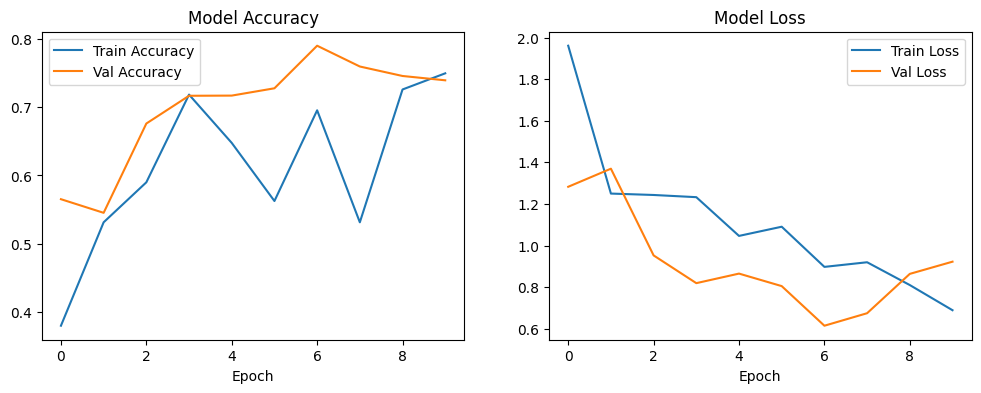

In [55]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save model

In [56]:
model.save('/kaggle/working/tomato_classifier_tf.h5')
print("Model saved as 'tomato_classifier_tf.h5'")

Model saved as 'tomato_classifier_tf.h5'


# Prediction Example

In [58]:
def predict_image(model, image_path, class_names):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    return predicted_class, confidence

In [74]:
pred_class, conf = predict_image(model, '/kaggle/input/plant-village/PlantVillage/Tomato_Bacterial_spot/0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG', detected_classes)
print(f"Predicted: {pred_class} (confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted: Tomato_Bacterial_spot (confidence: 0.23)


In [77]:
pred_class, conf = predict_image(model, '/kaggle/input/plant-village/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG', detected_classes)
print(f"Predicted: {pred_class} (confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: Tomato_healthy (confidence: 1.00)


In [61]:
pred_class, conf = predict_image(model, '/kaggle/input/plant-village/PlantVillage/Tomato_Leaf_Mold/0185befe-f0b5-4848-9677-f33c2237f4e9___Crnl_L.Mold 8729.JPG', detected_classes)
print(f"Predicted: {pred_class} (confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted: Tomato_Leaf_Mold (confidence: 0.86)


In [76]:
pred_class, conf = predict_image(model, '/kaggle/input/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/00139ae8-d881-4edb-925f-46584b0bd68c___YLCV_NREC 2944.JPG', detected_classes)
print(f"Predicted: {pred_class} (confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: Tomato__Tomato_YellowLeaf__Curl_Virus (confidence: 1.00)


In [78]:
pred_class, conf = predict_image(model, '/kaggle/input/plant-village/PlantVillage/Tomato_Late_blight/008ebb44-eb77-4843-b621-4b88b5df7d43___RS_Late.B 5188.JPG', detected_classes)
print(f"Predicted: {pred_class} (confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted: Tomato_Late_blight (confidence: 0.50)
